# Introduction 

**This is a basic CNN Model training notebook**

It is based on: 
- Thumbnail images
- Basic data transformation (using Albumentation):
    - resizing images to 512x512
    - normalizing pixel values
- CNN Architecture


**Todos:**

- Learn about Dataset & DataLoader
- add augmentations (albumentation)
- gem pooling

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "best_model" in filename:
            print(dirname+"/"+filename)
        continue

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-05-37.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-43-31.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_21-17-56.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_19-27-54.pth


In [2]:


import os
import gc
import cv2
import math
import copy
import time
import random
import glob

# For data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.express as px

import albumentations as A
from albumentations.pytorch import ToTensorV2

# For Image Models
import timm

# Albumentations for augmentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
# warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from cancer_utils_thumbnails import UBCDataset, data_transforms, GeM, EfficientNetB0, EarlyStopping, predict_val_dataset
from cancer_utils_thumbnails import fetch_scheduler, get_optimizer, get_dataloaders, get_class_weights

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning:

Cutout has been deprecated. Please use CoarseDropout



In [4]:
CONFIG = {
    "n_fold": 5,
    'fold': 1,
    "seed": 42,
    "img_size": 512,
    "crop_vertical":True,
    "model_name": "tf_efficientnet_b0_ns",
    "num_classes": 5,
    "valid_batch_size": 16,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    # "model_path": '/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-10-26_09-10-29.pth',
    "encoder_path": "/kaggle/input/efficientnetb0-training-crop-images/label_encoder_2023-11-06_19-27-47.pkl"
}

## 1. Data Preparation

In [5]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_thumbnails'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_thumbnails'
ALT_TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'
TMA_TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_images'


def get_train_file_path(df_train_row):
    if df_train_row.is_tma == False:
        return f"{TRAIN_DIR}/{df_train_row.image_id}_thumbnail.png"
    else:
        return f"{TMA_TRAIN_DIR}/{df_train_row.image_id}.png"



def get_test_file_path(image_id):
    if os.path.exists(f"{TEST_DIR}/{image_id}_thumbnail.png"):
        return f"{TEST_DIR}/{image_id}_thumbnail.png"
    else:
        return f"{ALT_TEST_DIR}/{image_id}.png"



In [6]:
encoder = joblib.load(CONFIG["encoder_path"])

In [7]:
df_test = pd.read_csv("/kaggle/input/UBC-OCEAN/test.csv")
df_test['file_path'] = df_test['image_id'].apply(get_test_file_path)
df_test["target_label"] = 0 
df_test

image_id  image_width  image_height  \
0        41        28469         16987   

                                           file_path  target_label  
0  /kaggle/input/UBC-OCEAN/test_thumbnails/41_thu...             0

In [8]:
'''
data_transforms = {
    "train": A.Compose([
        A.RandomResizedCrop(CONFIG['img_size'], CONFIG['img_size'], scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.2),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.CoarseDropout(p=0.2),
        A.Cutout(p=0.2),
        A.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225], 
            max_pixel_value=255.0, 
            p=1.0
        ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225], 
            max_pixel_value=255.0, 
            p=1.0
        ),
        ToTensorV2()], p=1.)
}'''

'\ndata_transforms = {\n    "train": A.Compose([\n        A.RandomResizedCrop(CONFIG[\'img_size\'], CONFIG[\'img_size\'], scale=(0.8, 1.0)),\n        A.HorizontalFlip(p=0.5),\n        A.RandomBrightnessContrast(p=0.2),\n        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.2),\n        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),\n        A.CoarseDropout(p=0.2),\n        A.Cutout(p=0.2),\n        A.Normalize(\n            mean=[0.485, 0.456, 0.406], \n            std=[0.229, 0.224, 0.225], \n            max_pixel_value=255.0, \n            p=1.0\n        ),\n        ToTensorV2()], p=1.),\n    \n    "valid": A.Compose([\n        A.Resize(CONFIG[\'img_size\'], CONFIG[\'img_size\']),\n        A.Normalize(\n            mean=[0.485, 0.456, 0.406], \n            std=[0.229, 0.224, 0.225], \n            max_pixel_value=255.0, \n            p=1.0\n        ),\n        ToTensorV2()], p=1.)\n}'

## 2. Load Models

In [9]:
model_filepaths = []
models = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "best_model" in filename:
            curr_model_path = dirname+"/"+filename
            print(curr_model_path)
            model_filepaths.append(curr_model_path)
        continue

for curr_model_path in sorted(model_filepaths):
    print(curr_model_path)
    model = EfficientNetB0(CONFIG['model_name'], CONFIG['num_classes'], pretrained=False)
    model.to(CONFIG['device']);
    model.load_state_dict(torch.load(curr_model_path, map_location=torch.device('cpu')))
    models.append(model)
    
print(f"Numer of models loaded: {len(models)}")

/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-05-37.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-43-31.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_21-17-56.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_19-27-54.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_19-27-54.pth


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning:

Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.



/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-05-37.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_20-43-31.pth
/kaggle/input/efficientnetb0-training-crop-images/best_model_checkpoint2023-11-06_21-17-56.pth
Numer of models loaded: 4


## 3. Model Validation 

In [10]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score

def predict_val_dataset(model, CONFIG, df_validate, encoder, TRAIN_DIR=None, val_size=1.0):
    
    valid_dataset = UBCDataset(df_validate, transforms=data_transforms["valid"])
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

    preds = []
    labels_list = []
    output_list = []
    valid_acc = 0.0

    with torch.no_grad():
        bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar: 
            # print(step)
            images = data['image'].to(CONFIG["device"], dtype=torch.float)
            labels = data['label'].to(CONFIG["device"], dtype=torch.long)

            batch_size = images.size(0)
            outputs = model(images)
            outputs = model.softmax(outputs)
            _, predicted = torch.max(outputs, 1)
            preds.append( predicted.detach().cpu().numpy() )
            labels_list.append(labels.detach().cpu().numpy())
            output_list.append(outputs.detach().cpu().numpy())
            acc = torch.sum( predicted == labels )
            valid_acc  += acc.item()
    valid_acc /= len(valid_loader.dataset)
    preds = np.concatenate(preds).flatten()
    labels_list = np.concatenate(labels_list).flatten()
    outputs = np.concatenate(output_list)
    pred_labels = encoder.inverse_transform( preds )

    # Calculate Balanced Accuracy
    bal_acc = balanced_accuracy_score(labels_list, preds)
    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(labels_list, preds)
    macro_f1 = f1_score(labels_list, preds, average='macro')
    micro_f1 = f1_score(labels_list, preds, average='micro')
    weighted_f1 = f1_score(labels_list, preds, average='weighted')

    print(f"Validation Accuracy: {valid_acc}")
    print(f"Balanced Accuracy: {bal_acc}")
    print(f"Macro F1-Score: {macro_f1}")
    print(f"Micro F1-Score: {micro_f1}")
    print(f"Weighted F1-Score: {weighted_f1}")
    print(f"Confusion Matrix: {conf_matrix}")

    # add to validation dataframe
    df_validate["pred"] = preds
    df_validate["pred_labels"] = pred_labels
    df_validate['outputs'] = outputs.tolist()

    return df_validate, preds, labels_list, outputs

In [11]:
df_train = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
dfs = [pd.DataFrame()]
print(df_train.shape)
df_train['file_path'] = df_train.apply(lambda row: get_train_file_path(row), axis=1)
df_train['target_label'] = encoder.transform(df_train['label'])
# use stratified K Fold for crossvalidation 
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG["seed"])
for fold, ( _, val_) in enumerate(skf.split(X=df_train, y=df_train.target_label)):
    df_train.loc[val_ , "kfold"] = int(fold)

all_labels = []
all_predictions = []
for fold, model in enumerate(models[:1]):
    fold += 1
    print("Evaluate Fold: ", fold)
    model.eval()
    model.to(CONFIG["device"])
    df_train_fold = df_train[df_train["kfold"]!=fold].reset_index(drop=True)
    df_valid_fold = df_train[df_train["kfold"]==fold].reset_index(drop=True)

    #train_dataset = UBCDataset(df_train_fold, transforms=data_transforms["train"])
    #train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
    #                          num_workers=2, shuffle=False, pin_memory=True)
    valid_dataset = UBCDataset(df_valid_fold, transforms=data_transforms["valid"])
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

    df_valid_fold, predictions, labels, outputs = predict_val_dataset(model, CONFIG, df_valid_fold, encoder, TRAIN_DIR, val_size=1)
    all_labels.extend(labels)
    all_predictions.extend(predictions)
    dfs.append(df_valid_fold)
df_validate = pd.concat(dfs, ignore_index=True)


(538, 5)
Evaluate Fold:  1


100%|██████████| 7/7 [00:58<00:00,  8.37s/it]

Validation Accuracy: 0.5740740740740741
Balanced Accuracy: 0.6137777777777778
Macro F1-Score: 0.5809937513466925
Micro F1-Score: 0.5740740740740741
Weighted F1-Score: 0.5689769925064043
Confusion Matrix: [[18  0  1  1  0]
 [ 5 12  5  2  1]
 [ 8 11 21  4  1]
 [ 0  1  3  5  0]
 [ 1  2  0  0  6]]


## 4. Error Analysis

In [12]:
df_validate.head()

image_id label  image_width  image_height  is_tma  \
0      1252  HGSC        60420         27480   False   
1      1289  HGSC        43940         26785   False   
2      1660    CC        83340         20447   False   
3      2097  HGSC        31696         21984   False   
4      2391  LGSC        58075         26192   False   

                                           file_path  target_label  kfold  \
0  /kaggle/input/UBC-OCEAN/train_thumbnails/1252_...             2    1.0   
1  /kaggle/input/UBC-OCEAN/train_thumbnails/1289_...             2    1.0   
2  /kaggle/input/UBC-OCEAN/train_thumbnails/1660_...             0    1.0   
3  /kaggle/input/UBC-OCEAN/train_thumbnails/2097_...             2    1.0   
4  /kaggle/input/UBC-OCEAN/train_thumbnails/2391_...             3    1.0   

   pred pred_labels                                            outputs  
0     0          CC  [0.4770008623600006, 0.06608158349990845, 0.04...  
1     1          EC  [0.2114485502243042, 0.5519810914993286, 0.078...  
2     0          CC  [0.8422099947929382, 0.06355640292167664, 0.04...  
3     1          EC  [0.005261595360934734, 0.6635409593582153, 0.1...  
4     3        LGSC  [0.0022721823770552874, 0.015305575914680958, ...

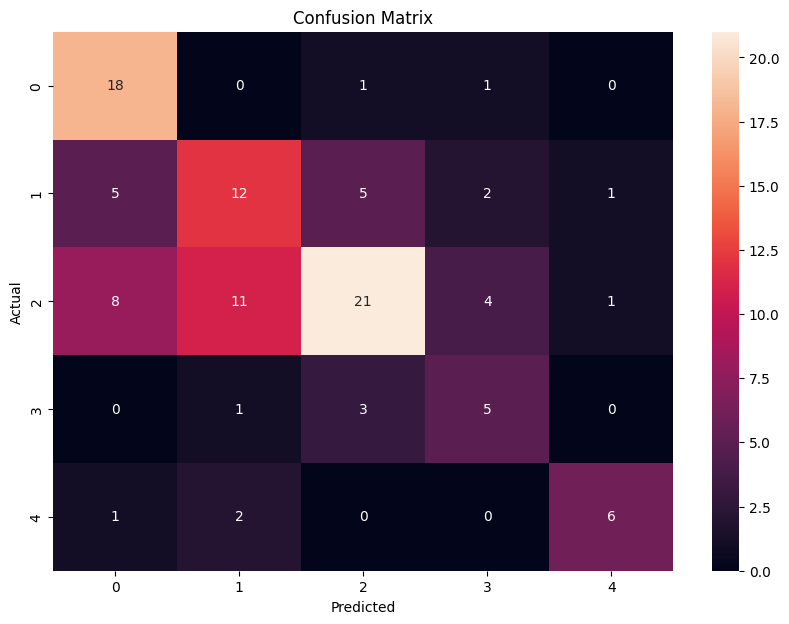

Accuracy: 0.5740740740740741
Precision: 0.5998931623931624
Recall: 0.5740740740740741
F1 Score: 0.5689769925064043
              precision    recall  f1-score     support
CC             0.562500  0.900000  0.692308   20.000000
EC             0.461538  0.480000  0.470588   25.000000
HGSC           0.700000  0.466667  0.560000   45.000000
LGSC           0.416667  0.555556  0.476190    9.000000
MC             0.750000  0.666667  0.705882    9.000000
accuracy       0.574074  0.574074  0.574074    0.574074
macro avg      0.578141  0.613778  0.580994  108.000000
weighted avg   0.599893  0.574074  0.568977  108.000000
Per-class accuracy:
Class 0: 0.9
Class 1: 0.48
Class 2: 0.4666666666666667
Class 3: 0.5555555555555556
Class 4: 0.6666666666666666


In [13]:



# Assuming df is your dataframe with the 'targets' and 'predictions' columns
# Sample dataframe structure
df = df_validate.copy()
df_correct = df[df["label"]==df["pred_labels"]]
df_incorrect = df[df["label"]!=df["pred_labels"]]

# Calculate the basic metrics
val_accuracy = accuracy_score(df['label'], df['pred_labels'])

val_precision, val_recall, val_f1_score, _ = precision_recall_fscore_support(df['label'], df['pred_labels'], average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(df['label'], df['pred_labels'])

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Output the metrics
print(f'Accuracy: {val_accuracy}')
print(f'Precision: {val_precision}')
print(f'Recall: {val_recall}')
print(f'F1 Score: {val_f1_score}')

# Calculate the metrics per class
class_report = classification_report(df['label'], df['pred_labels'], output_dict=True)

# Convert the classification report to a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Print out the classification report
print(class_report_df)

# Calculate per-class accuracy
# This method assumes that the classes are labeled from 0 to n_classes-1
n_classes = df['label'].nunique()
per_class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Print per-class accuracy
print("Per-class accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc}")

In [14]:
# Step 1: Identify Misclassifications for Each Class
unique_classes = df['label'].unique()
misclassified_by_class = {}

for class_label in unique_classes:
    # Create a mask for misclassified samples of the current class
    misclassified_mask = (df['label'] == class_label) & (df['label'] != df['pred_labels'])
    # Subset the dataframe based on the mask
    misclassified_by_class[class_label] = df[misclassified_mask]

"""
# Step 2: Misclassification Analysis for Each Class
for class_label, misclassified_df in misclassified_by_class.items():
    print(f"Analysis for class {class_label}:")
    # Visualize some misclassified images for the current class
    for index, sample in misclassified_df.iterrows():
        image = Image.open(sample['file_path'])  # Implement load_image function
        plt.imshow(image)
        plt.title(f"True label: {sample['label']} - Predicted: {sample['pred_labels']}")
        plt.show()
    
    # Analyze the distribution of prediction probabilities for misclassified images in the current class
    # Assuming you have a column 'prediction_probabilities' with the probabilities
    misclassified_probabilities = misclassified_df['prediction_probabilities']
    plt.hist(misclassified_probabilities)
    plt.title(f'Distribution of Prediction Probabilities for Misclassified Images in Class {class_label}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()
"""
    




'\n# Step 2: Misclassification Analysis for Each Class\nfor class_label, misclassified_df in misclassified_by_class.items():\n    print(f"Analysis for class {class_label}:")\n    # Visualize some misclassified images for the current class\n    for index, sample in misclassified_df.iterrows():\n        image = Image.open(sample[\'file_path\'])  # Implement load_image function\n        plt.imshow(image)\n        plt.title(f"True label: {sample[\'label\']} - Predicted: {sample[\'pred_labels\']}")\n        plt.show()\n    \n    # Analyze the distribution of prediction probabilities for misclassified images in the current class\n    # Assuming you have a column \'prediction_probabilities\' with the probabilities\n    misclassified_probabilities = misclassified_df[\'prediction_probabilities\']\n    plt.hist(misclassified_probabilities)\n    plt.title(f\'Distribution of Prediction Probabilities for Misclassified Images in Class {class_label}\')\n    plt.xlabel(\'Probability\')\n    plt.ylabel

In [15]:
def sample_and_show_images(df, N):
    """
    This function samples N correctly and N incorrectly classified images and shows them side by side.

    Parameters:
    - df: pandas.DataFrame containing the 'predictions' and 'targets' columns.
    - image_data_column: the name of the column in df that contains the image data.
    - N: number of samples to display for each category (correct/incorrect).
    """
    # Create a 'correct' column to indicate if the classification is correct
    df['correct'] = df['label'] == df['pred_labels']

    # Sample N correctly and N incorrectly classified images
    correct_samples = df[df['correct']]
    incorrect_samples = df[~df['correct']]
    print(f"Number of Correct Samples: {str(correct_samples.shape[0])}")
    print(f"Number of Incorrect Samples: {str(incorrect_samples.shape[0])}")
    
    correct_samples = correct_samples.sample(N).reset_index(drop=True)
    incorrect_samples = incorrect_samples.sample(N, replace=True).reset_index(drop=True)
    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(N, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Plot N correctly classified images
    for i in range(N):
        ax = axs[i,0]
        image = Image.open(correct_samples.iloc[i]['file_path']) 
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Correct: {correct_samples.iloc[i]['label']}")
        ax.axis('off')

    # Plot N incorrectly classified images
    for i in range(N):
        ax = axs[i, 1]
        image = Image.open(incorrect_samples.iloc[i]['file_path']) 
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Pred: {incorrect_samples.iloc[i]['pred_labels']} (True: {incorrect_samples.iloc[i]['label']})")
        ax.axis('off')

    plt.show()

HGSC
Number of Correct Samples: 21
Number of Incorrect Samples: 24


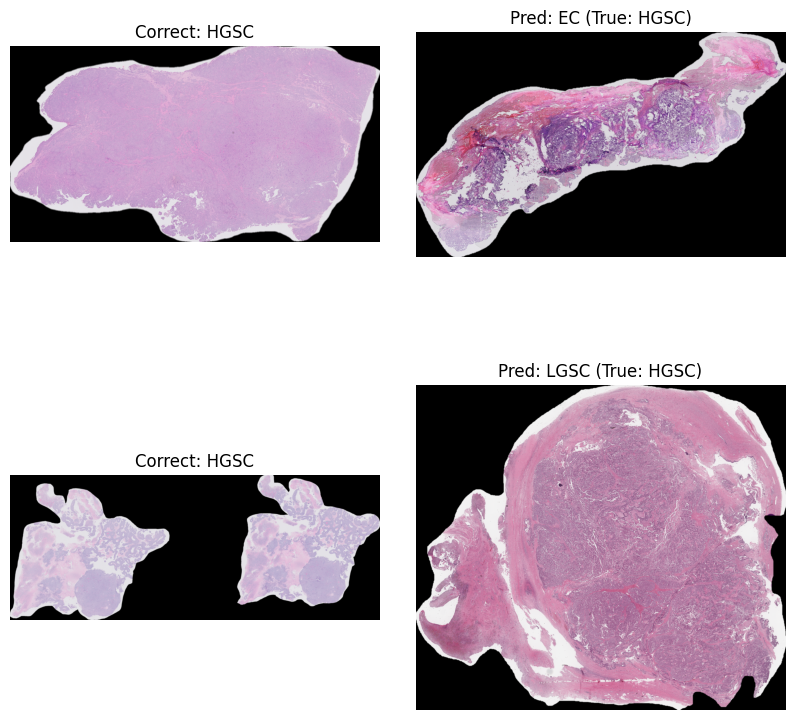

CC
Number of Correct Samples: 18
Number of Incorrect Samples: 2


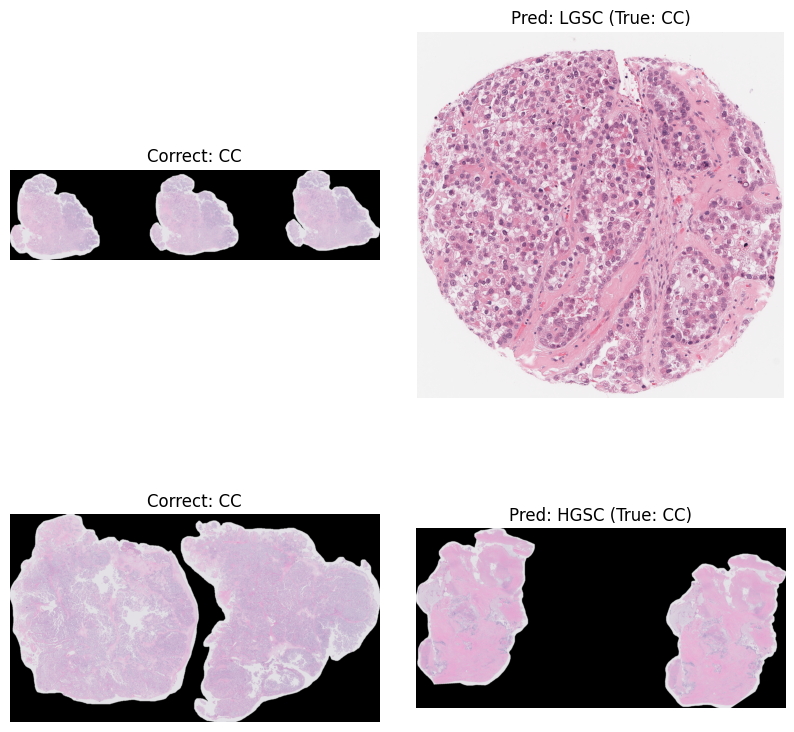

LGSC
Number of Correct Samples: 5
Number of Incorrect Samples: 4


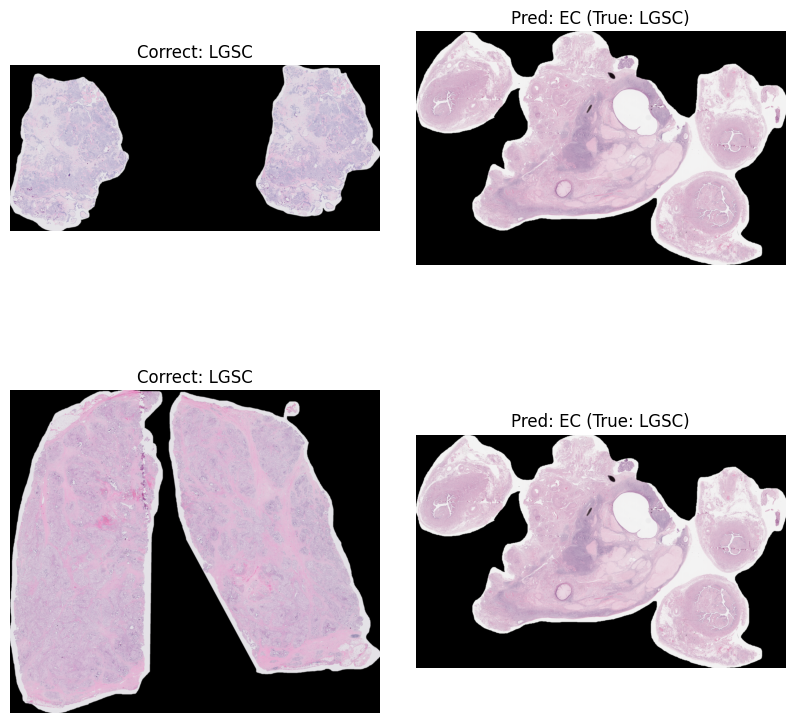

EC
Number of Correct Samples: 12
Number of Incorrect Samples: 13


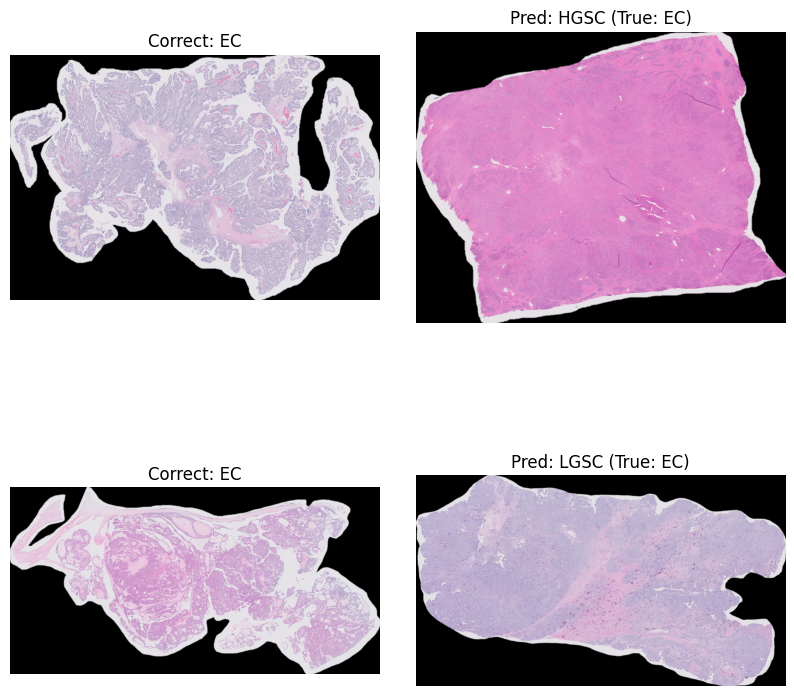

MC
Number of Correct Samples: 6
Number of Incorrect Samples: 3


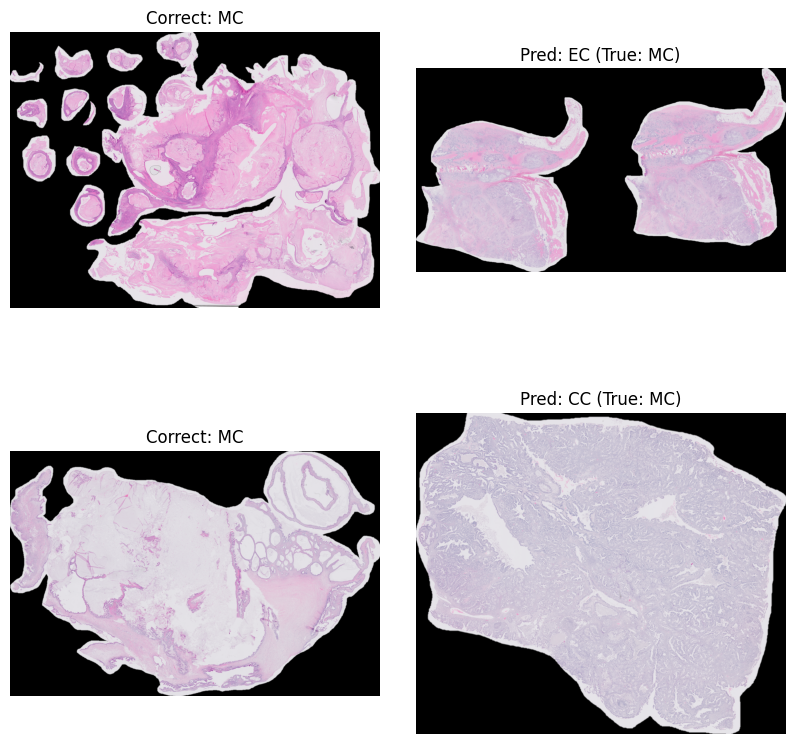

In [16]:
for class_ in df_validate["label"].unique():
    df_tmp = df_validate[df_validate["label"]==class_].reset_index(drop=True)
    print(class_)
    sample_and_show_images(df_tmp, 2)

In [17]:
# Analyze the distribution of prediction probabilities for misclassified images
# Assuming you have a column 'prediction_probabilities' with the probabilities
"""misclassified_probabilities = misclassified_df['outputs']
plt.hist(misclassified_probabilities)
plt.title('Distribution of Prediction Probabilities for Misclassified Images')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


# Step 3: Similarity Analysis
# Extract features using the model (You would need to implement the feature_extraction function)
# features = feature_extraction(model, misclassified_samples['image_path'])

# Use t-SNE to reduce the dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

# Visualize the features in 2D space
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=misclassified_samples['targets'])
plt.colorbar()
plt.title('t-SNE of Misclassified Images')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Step 4: False Positives/Negatives Analysis
# Calculate false positives and false negatives
# You would need to implement the calculate_fp_fn function
false_positives, false_negatives = calculate_fp_fn(df['targets'], df['predictions'])

# Analyze characteristics of false positives and negatives
# This part is specific to your data and may involve more complex analysis

# Note: The code above is a template and will need access to the actual image data and model to work.
# Functions like load_image, feature_extraction, and calculate_fp_fn need to be defined based on your dataset and model.

"""


"misclassified_probabilities = misclassified_df['outputs']\nplt.hist(misclassified_probabilities)\nplt.title('Distribution of Prediction Probabilities for Misclassified Images')\nplt.xlabel('Probability')\nplt.ylabel('Frequency')\nplt.show()\n\n\n# Step 3: Similarity Analysis\n# Extract features using the model (You would need to implement the feature_extraction function)\n# features = feature_extraction(model, misclassified_samples['image_path'])\n\n# Use t-SNE to reduce the dimensionality for visualization\ntsne = TSNE(n_components=2, random_state=42)\nreduced_features = tsne.fit_transform(features)\n\n# Visualize the features in 2D space\nplt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=misclassified_samples['targets'])\nplt.colorbar()\nplt.title('t-SNE of Misclassified Images')\nplt.xlabel('Component 1')\nplt.ylabel('Component 2')\nplt.show()\n\n# Step 4: False Positives/Negatives Analysis\n# Calculate false positives and false negatives\n# You would need to implement 

### Plotting Histograms

In [18]:
def plot_probability_histograms(correct_probs, incorrect_probs):
    """
    Plot histograms of predicted probabilities for correctly and incorrectly classified examples.

    Parameters:
    - correct_probs: array-like, predicted probabilities for correctly classified examples.
    - incorrect_probs: array-like, predicted probabilities for incorrectly classified examples.
    """
    plt.figure(figsize=(12, 6))

    # Histogram for correctly classified examples
    plt.hist(correct_probs, bins=20, alpha=0.5, label='Correctly Classified')

    # Histogram for incorrectly classified examples
    plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrectly Classified')

    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

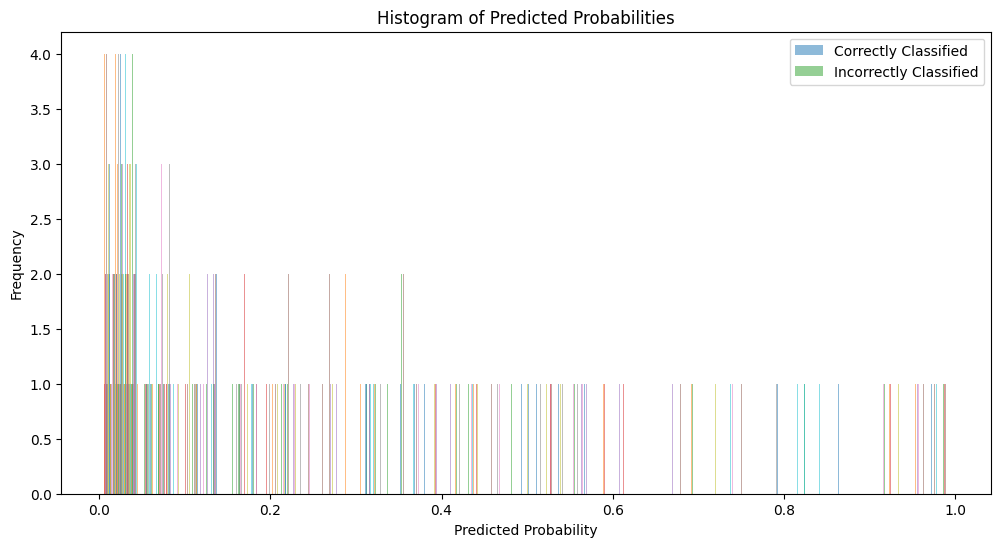

In [19]:
plot_probability_histograms(df_correct["outputs"], df_incorrect["outputs"])

In [20]:
def plot_classification_lines(df, probability_column, target_class, predicted_classes):
    """
    Plot a line plot with classes on the x-axis and probabilities on the y-axis.
    Each sample will be represented by a line. Correct classifications are in blue, incorrect in red.
    
    Parameters:
    - df: pandas DataFrame containing the classes and predicted probabilities for each sample.
    - class_labels: List of unique class labels.
    - probability_columns: List of column names in df for the predicted probabilities of each class.
    - correctness_column: Column name in df indicating if the classification was correct (boolean).
    """
    
    class_labels = df["label"].unique().tolist()
    df["is_correct"] = df["label"] == df["pred_labels"]
    df['Correctness'] = df["is_correct"].apply(lambda x: 'Correct' if x else 'Incorrect')
    df = df[(df["label"]==target_class) & (df["pred_labels"].isin(predicted_classes))]
    
    plot_data = []
    for index, row in df.iterrows():
        for class_label, prob in zip(class_labels, row[probability_column]):
            plot_data.append({
                'Sample': index,
                'Class': class_label,
                'Probability': prob,
                'Correct': row["is_correct"]
            })

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)
    
    # Map the correctness to color
    color_map = {True: 'blue', False: 'red'}
    plot_df['Color'] = plot_df['Correct'].map(color_map)
    
    # Plot using plotly express
    fig = px.line(plot_df, x='Class', y='Probability', line_group='Sample', color='Color',
                  title='Sample Classification Probabilities')
    
    # Update the layout to show legends and remove color axis
    fig.update_layout(showlegend=False)
    fig.update_traces(line=dict(width=1))
    
    fig.show()

In [21]:
plot_classification_lines(df,  "outputs", "EC", ["HGSC", "EC"])